In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 1
%aimport numpy_api_stats

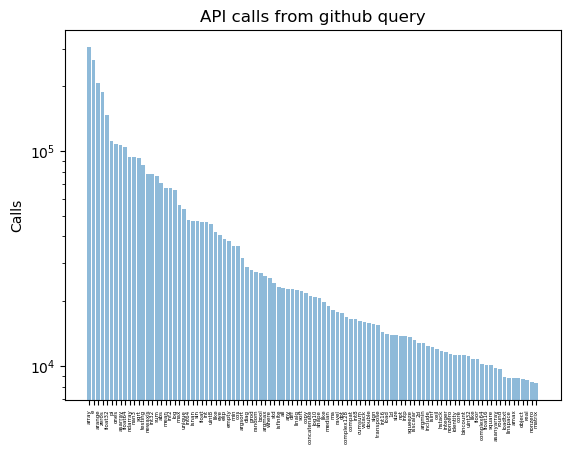

In [3]:
import numpy_api_stats as ns
import pandas as pd
ns.plot_results(pd.read_csv('results-20190402-090153.csv'),savefig=True,filename='results.png',dpi=200)

In [4]:
import os
os.environ['GOOGLE_CRED_DIR']=os.path.join(os.environ['HOME'],'creds')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.path.join(os.environ['GOOGLE_CRED_DIR'],'apt-footing-235018-aeb185ac9e31.json')

#### Investigate bigQuery public github dataset contents using bqhelper

In [5]:
#from google.cloud import bigquery
github_repos = ns.BigQueryHelper(active_project= "bigquery-public-data", 
                                       dataset_name = "github_repos")

In [6]:
github_repos.list_tables()

['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

In [7]:
api_results = ns.BigQueryHelper(active_project= "apt-footing-235018", 
                                       dataset_name = "NumpyAPI")

In [8]:
api_results.list_tables()

['content',
 'files',
 'functions',
 'imports',
 'methods',
 'ohNulllllll',
 'projects',
 'pypi_downloads_that_import_numpy',
 'pypi_downloads_this_week',
 'repos_that_import_numpy',
 'repos_that_import_numpy_split',
 'results',
 'results2',
 'results3',
 'sample_results',
 'watched',
 'watched_python',
 'watched_sample_files']

In [9]:
github_repos.table_schema('files')

,name,type,mode,description
0,repo_name,STRING,NULLABLE,None
1,ref,STRING,NULLABLE,None
2,path,STRING,NULLABLE,None
3,mode,INTEGER,NULLABLE,None
4,id,STRING,NULLABLE,None
5,symlink_target,STRING,NULLABLE,None


### Construct API datasets

In [10]:
import numpy as np
import pandas as pd

api = [(x, type(np.__getattribute__(x))) for x in dir(np) if not x.startswith('__')]
things = set([ x[1].__name__ for x in api])
names = set([ x[0] for x in api])
df_api = pd.DataFrame(api,columns=['name','type'])

array_type = df_api[df_api.name=='array']
things_of_array_type = df_api[df_api.type == array_type.type.values[0]]
#things_of_array_type

In [11]:
df_api[df_api.name=='linalg']

,name,type
339,linalg,<class 'module'>


In [12]:
GoogleSheet = pd.read_csv('NumPy API - Sheet2.csv')
names_from_sheet = GoogleSheet['NumPy API']

In [13]:
valid_names = set(names_from_sheet)-set(['Functions','bench',np.nan])

In [14]:
new_names = set(names)-set(names_from_sheet)

In [15]:
df_valid_from_sheet = df_api.set_index('name').loc[valid_names]
df_valid_from_sheet = df_valid_from_sheet.reset_index()
df_valid_from_sheet['type'] = df_valid_from_sheet.type.apply(lambda x: x.__name__)
df_valid_from_sheet.head()

,name,type
0,sum,function
1,record,type
2,log,ufunc
3,indices,function
4,geterr,function


#### How many of each type in the api are represented in the Google Sheet?

In [16]:
df_valid_from_sheet[['type','name']].groupby(['type']).count().sort_values('name')

,name
type,
CClass,1
NoneType,1
PytestTester,1
RClass,1
bool,1
int,1
IndexExpression,2
_typedict,2
str,2


#### Of which, the following have not been implemented

In [17]:
df_valid_from_sheet.set_index('type').loc[['CClass','NoneType','PytestTester','RClass','bool','IndexExpression','_typedict','str','nd_grid','_Feature','dict']]

,name
type,
CClass,c_
NoneType,newaxis
PytestTester,test
RClass,r_
bool,little_endian
IndexExpression,s_
IndexExpression,index_exp
_typedict,cast
_typedict,nbytes


#### Query Constructed for API functions..  

In [22]:
# Selecting just a few for demonstration, Query price is independent of # of regex though, so it is better to actually run
# with all at once.

funs = ns.select(api,'function')
mods = ns.select(api,'module')
ints = ns.select(api,'int')
floats = ns.select(api,'float')
ufuncs = ns.select(api,'ufunc')
api_list = funs[:2]+mods[:2]+ints[:2]+floats[:2]+ufuncs[:2]

In [ ]:
# Use all to build full query running 
#api_list=ns.build_api_list(api)

In [26]:
len(api_list)

10

In [27]:
import numpy_api_stats as ns
apq = ns.API_QUERY_FACTORY(api_list=api_list)
#apq = ns.API_QUERY_FACTORY()
print(apq.query)

SELECT
REGEXP_MATCH( c.content,'(np\\.|numpy\\.)add_newdoc\\(\\s?[A-Za-z0-9_.\\(\\)]*\\s?\\)' ) AS numpy_function_add_newdoc,
REGEXP_MATCH( c.content,'(np\\.|numpy\\.)alen\\(\\s?[A-Za-z0-9_.\\(\\)]*\\s?\\)' ) AS numpy_function_alen,
REGEXP_MATCH(c.content,'(import\\s+numpy\\._distributor_init|from\\s+numpy\\s+import\\s+_distributor_init|from\\s+numpy\\._distributor_init import\\s+[A-za-z0-9_.]+)' ) AS numpy_module__distributor_init,
REGEXP_MATCH(c.content,'(import\\s+numpy\\._globals|from\\s+numpy\\s+import\\s+_globals|from\\s+numpy\\._globals import\\s+[A-za-z0-9_.]+)' ) AS numpy_module__globals,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)ALLOW_THREADS' ) AS numpy_int_ALLOW_THREADS,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)BUFSIZE' ) AS numpy_int_BUFSIZE,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)Inf\\s*[\\*\\+\\-\\/]?' ) AS numpy_float_inf1,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)Infinity\\s*[\\*\\+\\-\\/]?' ) AS numpy_float_Infinity,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)abs\\(\\s?[A-Z

### AFter copying and pasting the above query into BigQuery and saving as sample_results... 

#####Unfortunately this doesn't work https://github.com/dask/dask/issues/3121 so we manually export results.

##### Pull data from bigQuery.  This is a one row table with a a few hundred columns so is relatively inexpensive to pull, but we'll download a local copy and work from that anyway to reduce wear on our ISP's routers.